# Vetorização
O objetivo desta etapa é gerar uma matriz de atributos.

In [1]:
import time
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

random_state = 133
%matplotlib inline
sns.set(rc={'figure.figsize':(15,5)})
warnings.filterwarnings(action = 'ignore')
mpl.rcParams['agg.path.chunksize'] = 10000
pd.set_option('display.max_colwidth' , 100)

Carregar dataframe pre-processado:

In [15]:
df = pd.read_feather('df_preprocessado.feather').set_index('index')
print('dimensão do dataset:', df.shape)

dimensão do dataset: (5598785, 22)


## Preparação

Vamos remover todas as colunas do tipo category ou de outros tipos mas que também sejam categorias.

In [17]:
df.dtypes

desc_eleicao                    category
uf                              category
ue                              category
partido                             int8
cargo                           category
candidato                          int32
documento                       category
data_despesa              datetime64[ns]
dia_despesa                        int64
semana_despesa            datetime64[ns]
mes_despesa               datetime64[ns]
fornecedor                         int32
setor_fornecedor                category
valor                            float64
tipo_despesa                    category
tipo_despesa_code                   int8
descricao_despesa                 object
descricao_wordcount                int64
descricao_charcount                int64
descricao_despesa_nulo             int64
documento_nulo                     int64
setor_fornecedor_nulo              int64
dtype: object

Os atributos numéricos serão normalizados.

Os atributos de data serão convertidos em atributos numéricos e normalizados.

In [18]:
df.columns

Index(['desc_eleicao', 'uf', 'ue', 'partido', 'cargo', 'candidato',
       'documento', 'data_despesa', 'dia_despesa', 'semana_despesa',
       'mes_despesa', 'fornecedor', 'setor_fornecedor', 'valor',
       'tipo_despesa', 'tipo_despesa_code', 'descricao_despesa',
       'descricao_wordcount', 'descricao_charcount', 'descricao_despesa_nulo',
       'documento_nulo', 'setor_fornecedor_nulo'],
      dtype='object')

In [23]:
colunas_matriz = [ 'dia_despesa', 'descricao_charcount', 'descricao_wordcount', 'descricao_despesa_nulo', 
                  'documento_nulo', 'setor_fornecedor_nulo', 'valor']
df[colunas_matriz].dtypes

dia_despesa                 int64
descricao_charcount         int64
descricao_wordcount         int64
descricao_despesa_nulo      int64
documento_nulo              int64
setor_fornecedor_nulo       int64
valor                     float64
dtype: object

In [24]:
df_matriz = df[colunas_matriz]
df_matriz.sample(5)

dia_despesa  descricao_charcount  descricao_wordcount  \
index                                                            
4047590         2189                   65                    9   
978742          2208                   57                    9   
1696788         2202                   24                    3   
4335096         2194                   29                    4   
5235122         2222                   30                    4   

         descricao_despesa_nulo  documento_nulo  setor_fornecedor_nulo   valor  
index                                                                           
4047590                       0               0                      1   100.0  
978742                        0               0                      1  1000.0  
1696788                       0               0                      0   150.0  
4335096                       0               0                      1   300.0  
5235122                       0               0                      0   114.0

### Normalização de variáveis

In [25]:
escalador_dia_despesa = StandardScaler()
escalador_descricao_charcount = StandardScaler()
escalador_descricao_wordcount = StandardScaler()
escalador_valor = StandardScaler()
escalador_descricao_despesa_nulo = StandardScaler()
escalador_documento_nulo = StandardScaler()
escalador_setor_fornecedor_nulo = StandardScaler()


df_matriz['dia_despesa'] = escalador_dia_despesa.fit_transform(df_matriz[['dia_despesa']].values)
df_matriz['descricao_charcount'] = escalador_descricao_charcount.fit_transform(df_matriz[['descricao_charcount']].values)
df_matriz['descricao_wordcount'] = escalador_descricao_wordcount.fit_transform(df_matriz[['descricao_wordcount']].values)
df_matriz['valor'] = escalador_valor.fit_transform(df_matriz[['valor']].values)
df_matriz['descricao_despesa_nulo'] = escalador_descricao_despesa_nulo.fit_transform(df_matriz[['descricao_despesa_nulo']].values)
df_matriz['documento_nulo'] = escalador_documento_nulo.fit_transform(df_matriz[['documento_nulo']].values)
df_matriz['setor_fornecedor_nulo'] = escalador_setor_fornecedor_nulo.fit_transform(df_matriz[['setor_fornecedor_nulo']].values)

In [26]:
df_matriz.head()

dia_despesa  descricao_charcount  descricao_wordcount  \
index                                                          
0        -0.839664            -0.216135            -0.159709   
1        -0.839664            -0.256787            -0.159709   
2        -0.839664            -0.216135            -0.159709   
3        -0.839664            -0.825919            -0.665500   
4        -0.839664            -0.256787            -0.159709   

       descricao_despesa_nulo  documento_nulo  setor_fornecedor_nulo     valor  
index                                                                           
0                    -0.05972       -0.262148               1.160402 -0.021829  
1                    -0.05972       -0.262148               1.160402 -0.021829  
2                    -0.05972       -0.262148               1.160402 -0.020400  
3                    -0.05972       -0.262148               1.160402 -0.020400  
4                    -0.05972       -0.262148               1.160402 -0.018495

### Experimento

In [27]:
mbk = MiniBatchKMeans(init='k-means++', n_clusters=8, batch_size=100,
                      n_init=3, max_no_improvement=10, verbose=0,
                      random_state = random_state)
mbk.fit(df_matriz)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=133,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [28]:
inertia = mbk.inertia_
silhouette = silhouette_score(df_matriz, mbk.labels_, sample_size = 1000, random_state = random_state)

In [29]:
print(inertia, silhouette)

17707112.260441236 0.36928981698996527


### Represenção em 2D
Com os melhores hiperparâmetros segundo silhouette, aplicaremos configurações escolhidas para visualizarmos em 2D.

In [30]:
def representar_2D (X):
    n_clusters = 8
    # #############################################################################
    # Compute clustering with MiniBatchKMeans

    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=100,
                          n_init=3, max_no_improvement=10, verbose=0,
                          random_state = random_state)            
            
    t0 = time.time()
    mbk.fit(X)
    t_mini_batch = time.time() - t0
    
    trunc = PCA(n_components=2, random_state=random_state)
    try:
        X_trunc = trunc.fit_transform(X.todense())
    except:
        X_trunc = trunc.fit_transform(X)
    
    silhouette = silhouette_score(X, mbk.labels_, sample_size = 1000, random_state = random_state)

    df_X_trunc = pd.DataFrame(X_trunc, columns=["x", "y"])
    df_X_trunc['label'] = mbk.labels_
    df_X_trunc.label = df_X_trunc.label.astype(str) #.str.slice(stop=3)
    # #############################################################################
    # Plot result
    fig, ax = plt.subplots(figsize=(15, 4))
    print ('train time: %.2fs\ninertia: %.2f\nsilhouette: %.4f' %
             (t_mini_batch, mbk.inertia_, silhouette))

    sns.scatterplot('x', 'y', hue = 'label', data=df_X_trunc, palette=sns.color_palette("Set2", n_clusters))
    ax.set_title('MiniBatchKMeans')
    ax.set_xticks(())
    ax.set_yticks(())
    plt.show()
    return df_X_trunc

Visualizando os dados

train time: 21.98s
inertia: 17707112.26
silhouette: 0.3693


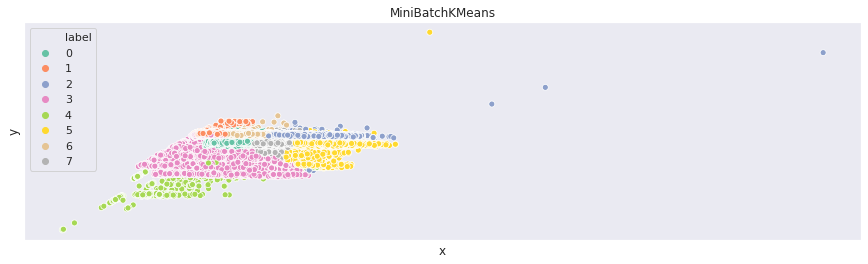

In [31]:
_ = representar_2D(df_matriz)

### Salvar matriz

In [32]:
pickle.dump(df_matriz, open("datasetFeatMatrix_std_semCategorias.pickle", "wb"))

### Análise dos extremos

In [33]:
df.iloc[_[_.y == _.y.max()].index[0]]

desc_eleicao                   Eleições Municipais 2016
uf                                                   SP
ue                                                  POÁ
partido                                               7
cargo                                          Vereador
candidato                                         36678
documento                                         Outro
data_despesa                        2010-08-30 00:00:00
dia_despesa                                           0
semana_despesa                      2010-08-30 00:00:00
mes_despesa                         2010-08-01 00:00:00
fornecedor                                       527642
setor_fornecedor                                  #NULO
valor                                              1050
tipo_despesa              Cessão ou locação de veículos
tipo_despesa_code                                     3
descricao_despesa               gm monza monza bke-2141
descricao_wordcount                             

In [34]:
df.iloc[_[_.x == _.x.max()].index[0]]

desc_eleicao                   Eleições Municipais 2016
uf                                                   RJ
ue                                       PARAÍBA DO SUL
partido                                              22
cargo                                          Vereador
candidato                                        384474
documento                                         Outro
data_despesa                        2016-09-14 00:00:00
dia_despesa                                        2207
semana_despesa                      2016-09-12 00:00:00
mes_despesa                         2016-09-01 00:00:00
fornecedor                                      1278891
setor_fornecedor                                  #NULO
valor                                             4e+07
tipo_despesa              Cessão ou locação de veículos
tipo_despesa_code                                     3
descricao_despesa             gm/prisma - placa kpu9630
descricao_wordcount                             

In [35]:
df.iloc[_[_.y == _.y.min()].index[0]]

desc_eleicao                         Eleição Suplementar de Rio das Ostras
uf                                                                      RJ
ue                                                          RIO DAS OSTRAS
partido                                                                 14
cargo                                                             Prefeito
candidato                                                           142450
documento                                                            #NULO
data_despesa                                           2018-06-27 00:00:00
dia_despesa                                                           2858
semana_despesa                                         2018-06-25 00:00:00
mes_despesa                                            2018-06-01 00:00:00
fornecedor                                                         1048956
setor_fornecedor                      Atividades de organizações políticas
valor                    